In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms
import cv2
import random

from models.MobilenetV2 import MobileNetV2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
dataset_directory = os.path.join(os.environ["HOME"], "Projects/Pytorch-Classification/datasets/cats_vs_dogs")

/home/avraham/Projects/Pytorch-Classification


In [62]:
images_paths = []
for f in os.listdir(dataset_directory):
    class_path = os.path.join(dataset_directory, f)
    for i in os.listdir(class_path):
        images_paths.append(os.path.join(class_path, i))
        
random.seed(42)
random.shuffle(images_paths)

train_size, val_size, test_size = 0.7, 0.2, 0.1 
train_images_filepaths = images_paths[:int(train_size*len(images_paths))]
val_images_filepaths = images_paths[int(train_size*len(images_paths))+1:-20]
test_images_filepaths = images_paths[-20:]

In [63]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

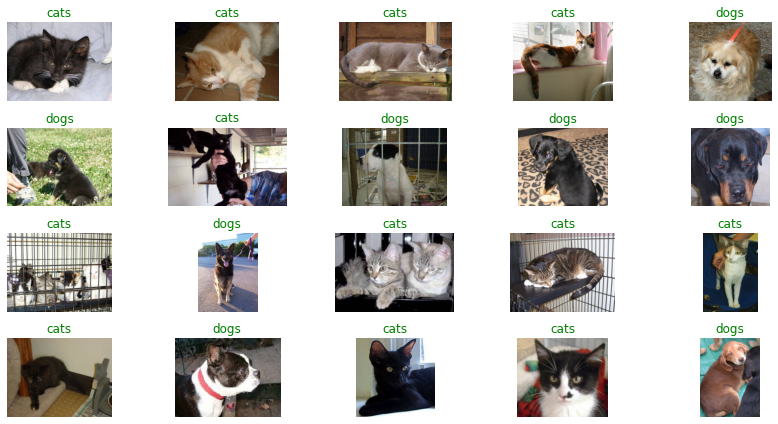

In [64]:
display_image_grid(test_images_filepaths)

25000
17500
2499
2501


In [22]:

BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3

In [68]:
dataset = torchvision.datasets.ImageFolder(data_dir, transform=TRANSFORM_IMG)
class_names = dataset.classes

In [69]:
train_size = int(0.8*len(dataset))
test_size = int(0.2*len(dataset))

In [70]:
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [71]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,  num_workers=4, pin_memory=True)


In [72]:
model = MobileNetV2(ch_in=3, n_classes=2)
summary(model, (3, 224, 224), device='cpu')
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
             ReLU6-9         [-1, 16, 112, 112]               0
    InvertedBlock-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 96, 112, 112]           1,536
      BatchNorm2d-12         [-1, 96, 112, 112]             192
            ReLU6-13         [-1, 96, 112, 112]               0
           Conv2d-14           [-1, 96,

MobileNetV2(
  (stem_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

In [78]:
def train_step(model, dataloader, loss_function, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        
        # move data to device
        x, y = x.to(device), y.to(device)
        
        # Forward
        y_predicted = model(x)
        
        # calc loss
        loss = loss_function(y_predicted, y)
        train_loss += loss.item()
        
        # zero gradients
        optimizer.zero_grad()
        
        # backward
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        # calc accuracy
        y_predicted_class = torch.argmax(torch.softmax(y_predicted, dim=1), dim=1)
        train_acc += (y_predicted_class == y).sum().item()/len(y_predicted)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [79]:
def test_step(model, dataloader, loss_function, device):
    
    model.eval()
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        
        for batch, (x, y) in enumerate(dataloader):
            
            # move data to device
            x, y = x.to(device), y.to(device)
            
            # Forward
            test_predicted = model(x)

            # calc loss
            loss = loss_function(test_predicted, y)
            test_loss += loss.item()
            
            # calc accuracy
            test_predicted_labels = test_predicted.argmax(dim=1)
            test_acc += ((test_predicted_labels == y).sum().item()/len(test_predicted_labels))
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

In [80]:
def train(model, train_data, test_data, optimizer, loss_function, epochs, device):
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_data, loss_function, optimizer, device)
        test_loss, test_acc = test_step(model, test_data, loss_function, device)
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          )
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [81]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

In [82]:
train(model, train_data_loader, test_data_loader, optimizer, loss_fn, EPOCHS, device)

Epoch: 1 | train_loss: 0.4161 | train_acc: 0.8104 | test_loss: 0.3595 | test_acc: 0.8379
Epoch: 2 | train_loss: 0.3366 | train_acc: 0.8522 | test_loss: 0.3575 | test_acc: 0.8492
Epoch: 3 | train_loss: 0.2814 | train_acc: 0.8781 | test_loss: 0.2492 | test_acc: 0.8904
Epoch: 4 | train_loss: 0.2447 | train_acc: 0.8969 | test_loss: 0.2208 | test_acc: 0.9077
Epoch: 5 | train_loss: 0.2003 | train_acc: 0.9150 | test_loss: 0.2051 | test_acc: 0.9129
Epoch: 6 | train_loss: 0.1767 | train_acc: 0.9287 | test_loss: 0.1849 | test_acc: 0.9257
Epoch: 7 | train_loss: 0.1589 | train_acc: 0.9364 | test_loss: 0.1940 | test_acc: 0.9169
Epoch: 8 | train_loss: 0.1374 | train_acc: 0.9437 | test_loss: 0.1717 | test_acc: 0.9257
Epoch: 9 | train_loss: 0.1259 | train_acc: 0.9505 | test_loss: 0.2026 | test_acc: 0.9197
Epoch: 10 | train_loss: 0.1180 | train_acc: 0.9539 | test_loss: 0.1740 | test_acc: 0.9293
Epoch: 11 | train_loss: 0.1036 | train_acc: 0.9581 | test_loss: 0.1740 | test_acc: 0.9315
Epoch: 12 | train_l

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1b1ee0550>
Traceback (most recent call last):
  File "/home/avraham/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/avraham/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1b1ee0550>
Traceback (most recent call last):
  File "/home/avraham/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/avraham/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_worker

Epoch: 41 | train_loss: 0.0191 | train_acc: 0.9926 | test_loss: 0.2440 | test_acc: 0.9297
Epoch: 42 | train_loss: 0.0185 | train_acc: 0.9943 | test_loss: 0.2001 | test_acc: 0.9375
Epoch: 43 | train_loss: 0.0229 | train_acc: 0.9919 | test_loss: 0.2887 | test_acc: 0.9241


KeyboardInterrupt: 

In [83]:
# save model
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')

In [85]:
# load model
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=MobileNetV2
  (stem_conv): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU6)
  )
  (layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=InvertedBlock
      (layers): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU6)
        )
        (1): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU6)